<a href="https://colab.research.google.com/github/rahiakela/deep-learning-research-and-practice/blob/main/deep-learning-with-pytorch-step-by-step/Part-III-NLP/03_self_attention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Self-Attention

What if we replaced the recurrent layer with an attention mechanism?

That’s the main objective of Transformer architecture, based on a self-attention mechanism, that now completely dominate the NLP landscape.

The recurrent layer in the encoder took the source sequence in and, one by one, generated hidden states. But we don’t have to generate hidden states like that. We can use another, separate, attention mechanism to replace the encoder.

These separate attention mechanisms are called self-attention
mechanisms since all of their inputs—"keys," "values," and
"query"—are internal to either an encoder or a decoder.

The attention mechanism, where "keys" and "values" come from the encoder, but the "query" comes from the decoder, is going to be referred to as
cross-attention.

Once again, the affine transformations we’re applying to "keys,"
"queries," and "values" may also be used to change the
dimensionality from the number of input dimensions to the
number of hidden dimensions (this transformation was formerly
performed by the recurrent layer).

We’ll start by generating a synthetic dataset and then  will:

1. use self-attention mechanisms to replace recurrent layers in both the encoder and the decoder,
2. understand the importance of the target mask to avoid data leakage,
3. learn how to use positional encoding



##Setup

In [1]:
try:
    import google.colab
    import requests
    url = 'https://raw.githubusercontent.com/dvgodoy/PyTorchStepByStep/master/config.py'
    r = requests.get(url, allow_redirects=True)
    open('config.py', 'wb').write(r.content)
except ModuleNotFoundError:
    pass

from config import *
config_chapter9()
# This is needed to render the plots in this chapter
from plots.chapter8 import *
from plots.chapter9 import *

Finished!


In [2]:
import copy
import numpy as np

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, random_split, TensorDataset

from data_generation.square_sequences import generate_sequences
from stepbystep.v4 import StepByStep

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [4]:
class Attention(nn.Module):
  def __init__(self, hidden_dim, input_dim=None, proj_values=False):
    super().__init__()

    self.d_k = hidden_dim
    self.input_dim = hidden_dim if input_dim is None else input_dim
    self.proj_values = proj_values

    # Affine transformations for Q, K, and V
    self.QUERY = nn.Linear(self.input_dim, hidden_dim)
    self.KEY = nn.Linear(self.input_dim, hidden_dim)
    self.VALUE = nn.Linear(self.input_dim, hidden_dim)

    # a placeholder for the attention scores
    self.alphas = None

  def init_keys(self, keys):
    self.keys = keys
    self.proj_keys = self.KEY(self.keys)
    self.values = self.VALUE(self.keys) if self.proj_values else self.keys

  def score_function(self, query):
    proj_query = self.QUERY(query)
    # scaled dot product
    # (N, 1, H) x (N, H, L) -> (N, 1, L)
    dot_products = torch.bmm(proj_query, self.proj_keys.permute(0, 2, 1))
    scores = dot_products / np.sqrt(self.d_k)
    return scores

  def forward(self, query, mask=None):
    # Step-1: compute alignment scores (scaled dot product)
    scores = self.score_function(query)   # Query is batch-first N, 1, H
    if mask is not None:
      scores = scores.masked_fill(mask==0, -1e-9)

    # Step-2: compute attention scores (alphas)
    alphas = F.softmax(scores, dim=-1)    # N, 1, L
    self.alphas = alphas.detach()

    # Step-3: generate the context vector
    context = torch.bmm(alphas, self.values)  # N, 1, L x N, L, H -> N, 1, H
    return context


class MultiHeadAttention(nn.Module):

  def __init__(self, n_heads, d_model, input_dim=None, proj_values=True):
    super().__init__()

    self.linear = nn.Linear(n_heads * d_model, d_model)
    self.attention_head = nn.ModuleList([Attention(d_model, input_dim=input_dim, proj_values=proj_values) for _ in range(n_heads)])

  def init_keys(self, key):
    for attention in self.attention_head:
      attention.init_keys(key)

  @property
  def alphas(self):
    # Shape: n_heads, N, 1, L (source)
    return torch.stack([attention.alphas for attention in self.attention_head], dim=0)

  def output_function(self, contexts):
    # N, 1, n_heads * D
    concatenated = torch.cat(contexts, axis=-1)
    # Linear transformation to go back to original dimension
    output = self.linear(concatenated)  # N, 1, D
    return output

  def forward(self, query, mask=None):
    contexts = [attention(query, mask=mask) for attention in self.attention_head]
    output = self.output_function(contexts)
    return output

## Dataset

We’ll keep drawing the same squares as before, but this time we’ll draw the first
two corners ourselves (the source sequence) and ask our model to predict the
next two corners (the target sequence).

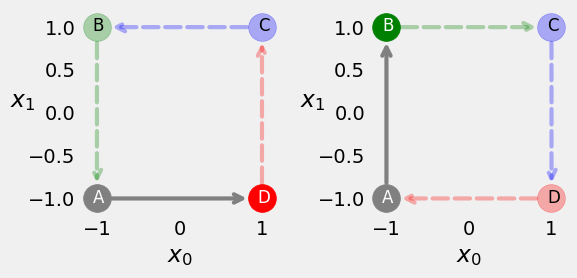

In [5]:
fig = counter_vs_clock(binary=False)

Since there are four corners to start from and two directions to follow, there are
effectively eight possible sequences (solid colors indicate the corners in the source
sequence, semi-transparent colors, the target sequence).

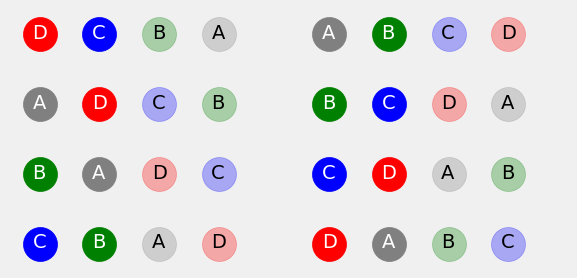

In [6]:
fig = plot_sequences(binary=False, target_len=2)

Since the desired output of our model is a sequence of coordinates (x0, x1), we’re
dealing with a regression problem now.

Therefore, we’ll be using a typical mean
squared error loss to compare the predicted and actual coordinates for the two
points in the target sequence.

Let’s generate 256 random noisy squares.

In [7]:
points, directions = generate_sequences(n=256, seed=13)

And then let’s visualize the first five squares.

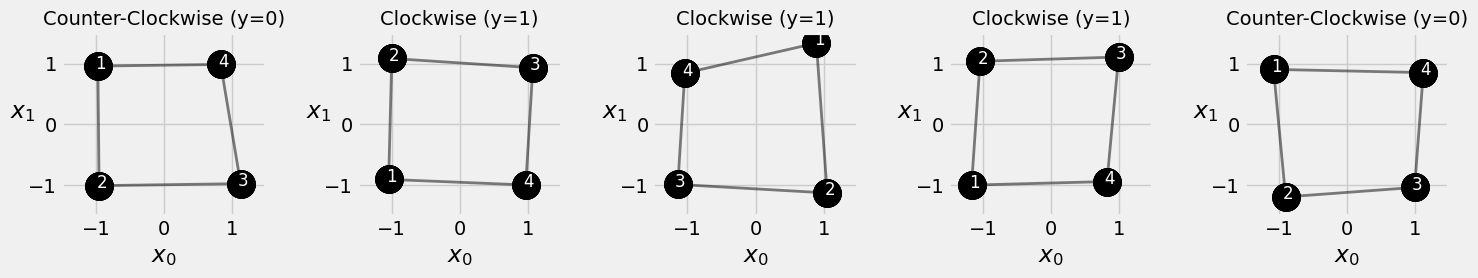

In [8]:
fig = plot_data(points, directions, n_rows=1)

##Encoder

In the encoder's self-attention: The source sequence (in
red) works as "keys" (K), "values" (V), and "queries (Q)" as well.

Did you notice I mentioned, "queries," plural, instead of "query"?

In the encoder, each data point is a "query" (the red arrow
entering the self-attention mechanism from the side), and thus
produces its own context vector using alignment vectors for
every data point in the source sequence, including itself. This
means it is possible for a data point to generate a context vector
that is only paying attention to itself.

![](https://github.com/rahiakela/deep-learning-research-and-practice/blob/main/deep-learning-with-pytorch-step-by-step/Part-III-NLP/images/encoder_self_attention.png?raw=1)

As the diagram above illustrates, each context vector produced by the self-attention mechanism goes through a feed-forward network to generate a "hidden state" as output.

We can dive deeper into the inner workings of the self-attention
mechanism.

![](https://github.com/rahiakela/deep-learning-research-and-practice/blob/main/deep-learning-with-pytorch-step-by-step/Part-III-NLP/images/encoder_self.png?raw=1)

Let’s focus on the self-attention mechanism on the left, used to generate the
"hidden state" ($h_{00}, h_{01}$) corresponding to the first data point in the source sequence ($x_{00}, x_{01}$), and see how it works in great detail:

* The transformed coordinates of the first data point are used as "query" ($Q$).
* This "query" ($Q$) will be paired, independently, with each of the two "keys" ($K$), one of them being a different transformation of the same coordinates ($x_{00}, x_{01}$), the other being a transformation of the second data point ($x_{10}, x_{11}$).
* The pairing above will result in two attention scores (alphas, $s_0$ and $s_1$) that, multiplied by their corresponding "values" ($V$), are added up to become the context vector:
$$
\Large
\alpha_{\color{blue}{0}\color{red}0}, \alpha_{{\color{blue}{0}\color{red}1}} = \text{softmax}(\frac{\color{red}{Q_0}\color{black}\cdot K_0}{\sqrt{2}}, \frac{\color{red}{Q_0}\color{black}\cdot K_1}{\sqrt{2}})
$$
$$
\Large
\color{blue}{\text{context vector}_0}\color{black}= \alpha_{\color{blue}{0}\color{red}0}V_0 + \alpha_{{\color{blue}{0}\color{red}1}}V_1
$$
* Next, the context vector goes through the feed-forward network, and the first "hidden state" is born!

Next, we shift our focus to the self-attention mechanism on the right:

* It is the second data point's turn to be the "query" (Q), being paired with both "keys" (K), generating attention scores and a context vector, resulting in the second "hidden state":
$$
\Large
\alpha_{\color{blue}{1}\color{red}0}, \alpha_{{\color{blue}{1}\color{red}1}} = \text{softmax}(\frac{\color{red}{Q_1}\color{black}\cdot K_0}{\sqrt{2}}, \frac{\color{red}{Q_1}\color{black}\cdot K_1}{\sqrt{2}})
$$
$$
\Large
\color{blue}{\text{context vector}_1}\color{black}= \alpha_{\color{blue}{1}\color{red}0}V_0 + \alpha_{{\color{blue}{1}\color{red}1}}V_1
$$

>As you probably already noticed, the context vector (and thus the "hidden state") associated with a data point is basically a function of the corresponding "query" ($Q$), and everything else ("keys" ($K$), "values" ($V$), and the parameters of the self-attention mechanism) is held constant for all queries.

Therefore, we can simplify a bit our previous diagram and depict only one self-attention mechanism, assuming it will be fed a different "query" ($Q$) every time.

![](https://github.com/rahiakela/deep-learning-research-and-practice/blob/main/deep-learning-with-pytorch-step-by-step/Part-III-NLP/images/encoder_self_attention2.png?raw=1)

The alphas are the attention scores, and they are organized as follows in the
alphas attribute.

$$
\Large
\begin{array}{c|cc}
& \text{source}\\
\text{target}& \color{red}{x_0} & \color{red}{x_1} \\
\hline
 \color{blue}{h_0} & \alpha_{\color{blue}{0}\color{red}0} & \alpha_{{\color{blue}{0}\color{red}1}} \\
 \color{blue}{h_1} & \alpha_{\color{blue}{1}\color{red}0} & \alpha_{{\color{blue}{1}\color{red}1}}
\end{array}
$$

For the encoder, the shape of the alphas attribute is given by ($N, L_{source}, L_{source}$) since it is looking at itself.

>Even though I’ve described the process as if it were sequential, these operations can be parallelized to generate all "hidden states" at once, which is much more efficient than using a recurrent layer that is sequential in nature.

We can also use an even more simplified diagram of the encoder that abstracts the nitty-gritty details of the self-attention mechanism.

![](https://github.com/rahiakela/deep-learning-research-and-practice/blob/main/deep-learning-with-pytorch-step-by-step/Part-III-NLP/images/transf_encself.png?raw=1)

The code for our encoder with self-attention is actually quite simple since most of the moving parts are inside the attention heads:

In [9]:
class Encoder(nn.Module):
  def __init__(self, n_heads, d_model, ff_units, n_features=None):
    super().__init__()

    self.n_heads = n_heads
    self.d_model = d_model
    self.ff_units = ff_units
    self.n_features = n_features

    self.self_attention_heads = MultiHeadAttention(n_heads, d_model, input_dim=n_features)
    self.feed_forward_network = nn.Sequential(
        nn.Linear(d_model, ff_units),
        nn.ReLU(),
        nn.Linear(ff_units, d_model)
    )

  def forward(self, query, mask=None):
    self.self_attention_heads.init_keys(query)
    self_attention = self.self_attention_heads(query, mask)  # context vector
    output = self.feed_forward_network(self_attention)       # hidden state
    return output

The mask argument should receive the source mask; that is, the mask we use to
ignore padded data points in our source sequence.

Let’s create an encoder and feed it a source sequence:

In [10]:
full_seq = (torch.tensor([
  [-1, -1],
  [-1, 1],
  [1, 1],
  [1, -1]
]).float().view(1, 4, 2))
full_seq

tensor([[[-1., -1.],
         [-1.,  1.],
         [ 1.,  1.],
         [ 1., -1.]]])

In [11]:
source_seq = full_seq[:, :2]  # first two corners
target_seq = full_seq[:, 2:]  # last two corners

Now, let’s encode the source sequence and take the final hidden state.

In [12]:
torch.manual_seed(11)

encoder = Encoder(n_heads=3, d_model=2, ff_units=10, n_features=2)

query = source_seq
encoder_states = encoder(query)
encoder_states

tensor([[[-0.0498,  0.2193],
         [-0.0642,  0.2258]]], grad_fn=<ViewBackward0>)

It produced a sequence of states that will be the input of the (cross-)attention mechanism used by the decoder.

##Decoder

In cross-attention, the decoder provided a "query" ($Q$), which served not only as input but also got concatenated to the resulting context vector. That won’t be the case anymore!

Instead of concatenation, the context vector will go through a feed-forward network in the decoder to generate the predicted coordinates.

![](https://github.com/rahiakela/deep-learning-research-and-practice/blob/main/deep-learning-with-pytorch-step-by-step/Part-III-NLP/images/cross_attn.png?raw=1)

If you’re wondering why the concatenation part is removed, here comes the
answer: We’re using self-attention as a decoder too.

There is one main difference between the encoder and the
decoder—the latter includes a cross-attention mechanism.

In [13]:
class Decoder(nn.Module):

  def __init__(self, n_heads, d_model, ff_units, n_features=None):
    super().__init__()

    self.n_heads = n_heads
    self.d_model = d_model
    self.ff_units = ff_units
    self.n_features = d_model if n_features is None else n_features

    self.self_attention_heads = MultiHeadAttention(n_heads, d_model, input_dim=self.n_features)
    self.cross_attention_heads = MultiHeadAttention(n_heads, d_model)

    self.feed_forward_network = nn.Sequential(
        nn.Linear(d_model, ff_units),
        nn.ReLU(),
        nn.Linear(ff_units, self.n_features)
    )

  def init_keys(self, states):
    self.cross_attention_heads.init_keys(states)

  def forward(self, query, source_mask=None, target_mask=None):
    self.self_attention_heads.init_keys(query)

    self_attention = self.self_attention_heads(query, target_mask)
    cross_attention = self.cross_attention_heads(self_attention, source_mask)
    output = self.feed_forward_network(cross_attention)

    return output

Once again, we can dive deeper into the inner workings of the self-attention
mechanism.

![](https://github.com/rahiakela/deep-learning-research-and-practice/blob/main/deep-learning-with-pytorch-step-by-step/Part-III-NLP/images/decoder_self.png?raw=1)


There is one small difference in the self-attention architecture between encoder and decoder: The feed-forward network in the decoder sits atop the cross-attention mechanism instead of the self-attention
mechanism.

The feed-forward network also maps the decoder’s output from the
dimensionality of the model (`d_model`) back to the number of features, thus
yielding predictions.

We can also use a simplified diagram for the decoder.

![](https://github.com/rahiakela/deep-learning-research-and-practice/blob/main/deep-learning-with-pytorch-step-by-step/Part-III-NLP/images/transf_decself.png?raw=1)

The decoder’s first input $(x_{10}, x_{11})$ is the last known element of the source sequence, as usual. The source mask is the same mask used to ignore padded data points in the encoder.

###Teacher Forcing

Now, let’s define the shifted target sequence, which
includes the last known element of the source sequence and all elements in the
target sequence but the last one.

![](https://github.com/rahiakela/deep-learning-research-and-practice/blob/main/deep-learning-with-pytorch-step-by-step/Part-III-NLP/images/shifted_target.png?raw=1)

In [14]:
shifted_seq = torch.cat([source_seq[:, -1:], target_seq[:, :-1]], dim=1)

The shifted target sequence was already used, when we used teacher forcing. There, at every step (after the first one), it
randomly chose as the input to the subsequent step either an actual element from that sequence or a prediction. It worked very well with recurrent layers that were sequential in nature. But this isn’t the case anymore.

>One of the advantages of self-attention over recurrent layers is
that operations can be parallelized. No need to do anything
sequentially anymore, teacher forcing included. This means we’re
using the whole shifted target sequence at once as the "query"
argument of the decoder.

That’s very nice and cool, sure, but it raises one big problem involving the…

###Attention Scores

To understand what the problem is, let’s look at the context vector that will result in the first "hidden state" produced by the decoder, which, in turn, will lead to the first prediction:

$$
\Large
\alpha_{\color{green}{2}\color{red}1}, \alpha_{{\color{green}{2}\color{red}2}} = \text{softmax}(\frac{\color{red}{Q_1}\color{black}\cdot K_1}{\sqrt{2}}, \frac{\color{red}{Q_1}\color{black}\cdot K_2}{\sqrt{2}})
\\
\Large
\color{green}{\text{context vector}_2}\color{black}= \alpha_{\color{green}{2}\color{red}1}V_1 + \alpha_{{\color{green}{2}\color{red}2}}V_2
$$

What’s the problem with it?

The problem is that it is using a "key" ($K_2$) and a "value" ($V_2$) that are
transformations of the data point it is trying to predict.

>In other words, the model is being allowed to cheat by peeking
into the future because we’re giving it all data points in the
target sequence except the very last one.

If we look at the context vector corresponding to the last prediction, it should be clear that the model simply cannot cheat (there’s no $K_3$ or $V_3$):

$$
\Large
\alpha_{\color{green}{3}\color{red}1}, \alpha_{{\color{green}{3}\color{red}2}} = \text{softmax}(\frac{\color{red}{Q_2}\color{black}\cdot K_1}{\sqrt{2}}, \frac{\color{red}{Q_2}\color{black}\cdot K_2}{\sqrt{2}})
\\
\Large
\color{green}{\text{context vector}_3}\color{black}= \alpha_{\color{green}{3}\color{red}1}V_1 + \alpha_{{\color{green}{3}\color{red}2}}V_2
$$

We can also check it quickly by looking at the subscript indices: As long as the indices of the "values" are lower than the index of the context vector, there is no cheating.

By the way, it is even easier to check what’s happening if we use the
alphas matrix:

$$
\Large
\begin{array}{c|cc}
& \text{source}\\
\text{target}& \color{red}{x_1} & \color{red}{x_2} \\
\hline
 \color{green}{h_2} & \alpha_{\color{green}{2}\color{red}1} & \alpha_{{\color{green}{2}\color{red}2}} \\
 \color{green}{h_3} & \alpha_{\color{green}{3}\color{red}1} & \alpha_{{\color{green}{3}\color{red}2}}
\end{array}
$$

For the decoder, the shape of the alphas attribute is given by $(N, L_{target}, L_{target})$ since
it is looking at itself. Any alphas above the diagonal are, literally, cheating codes.

We need to force the self-attention mechanism to ignore them.



###Target Mask (Training)

The purpose of the target mask is to zero attention scores for "future" data
points.

In our example, that’s the alphas matrix we’re aiming for:

$$
\Large
\begin{array}{c|cc}
& \text{source}\\
\text{target}& \color{red}{x_1} & \color{red}{x_2} \\
\hline
 \color{green}{h_2} & \alpha_{\color{green}{2}\color{red}1} & 0 \\
 \color{green}{h_3} & \alpha_{\color{green}{3}\color{red}1} & \alpha_{{\color{green}{3}\color{red}2}}
\end{array}
$$

Therefore we need a mask that flags every element above the
diagonal as invalid, as we did with the padded data points in the
source mask. The shape of the target mask, though, must match
the shape of the alphas attribute: $(N, L_{target}, L_{target})$.

We can create a function to generate the mask for us:

In [15]:
def subsequent_mask(size):
  attention_shape = (1, size, size)
  subsequent_mask = (1 - torch.triu(torch.ones(attention_shape), diagonal=1)).bool()
  return subsequent_mask

In [16]:
subsequent_mask(2) # 1, L, L

tensor([[[ True, False],
         [ True,  True]]])

We must use this mask while querying the decoder to prevent it
from cheating.

You can choose to use an additional mask to
"hide" more data from the decoder if you wish, but the
subsequent mask is a necessity with the self-attention decoder.

Let’s see it in practice:

In [17]:
torch.manual_seed(13)

decoder = Decoder(n_heads=3, d_model=2, ff_units=10, n_features=2)
decoder.init_keys(encoder_states)

query = shifted_seq
decoder_output = decoder(query, target_mask=subsequent_mask(2))

decoder.self_attention_heads.alphas

tensor([[[[0.4743, 0.5257],
          [0.4011, 0.5989]]],


        [[[0.7748, 0.2252],
          [0.4264, 0.5736]]],


        [[[0.5950, 0.4050],
          [0.6304, 0.3696]]]])

###Target Mask (Evaluation/Prediction)

The only difference between training and evaluation, concerning the target mask, is that we’ll use larger masks as we go.

The very first mask is actually trivial since
there are no elements above the diagonal:

$$
\Large
1^{\text{st}}\ \text{Step}
\Large
\begin{cases}
\begin{array}{c|cc}
& \text{source}\\
\text{target}& \color{red}{x_1} & \\
\hline
 \color{green}{h_2} & \alpha_{\color{green}{2}\color{red}1}
\end{array}
\end{cases}
$$

At evaluation / prediction time we only have the source sequence, and, in our
example, we use its last element as input for the decoder:

In [18]:
inputs = source_seq[:, -1:]
target_mask = subsequent_mask(1)
output = decoder(inputs, target_mask)
output

tensor([[[0.4132, 0.3728]]], grad_fn=<ViewBackward0>)

The mask is not actually masking anything in this case, and we get a prediction for the coordinates of $x_2$ as expected.

Previously, this prediction would have been used
as the next input, but things are a bit different now.

>The self-attention decoder expects the full sequence as "query,"
so we concatenate the prediction to the previous "query."

In [19]:
inputs = torch.cat([inputs, output[:, -1:, :]], dim=-2)
inputs

tensor([[[-1.0000,  1.0000],
         [ 0.4132,  0.3728]]], grad_fn=<CatBackward0>)

Now there are two data points for querying the decoder, so we adjust the mask
accordingly:

$$
\Large
2^{\text{nd}}\ \text{Step}
\Large
\begin{cases}
\begin{array}{c|cc}
& \text{source}\\
\text{target}& \color{red}{x_1} & \color{green}{x_2} \\
\hline
 \color{green}{h_2} & \alpha_{\color{green}{2}\color{red}1} & 0 \\
 \color{green}{h_3} & \alpha_{\color{green}{3}\color{red}1} & \alpha_{{\color{green}{3}\color{green}2}}
\end{array}
\end{cases}
$$

>The mask guarantees that the predicted $x_2$ (in the first step)
won’t change the predicted $x_2$ (in the second step), because
predictions are made based on past data points only.

In [20]:
target_mask = subsequent_mask(2)
output = decoder(inputs, target_mask)
output

tensor([[[0.4133, 0.3728],
         [0.4132, 0.3728]]], grad_fn=<ViewBackward0>)

These are the predicted coordinates of both $x_2$ and $x_3$. They are very close to each other, but that’s just because we’re using an untrained model to illustrate the mechanics of using target masks for prediction.

The last prediction is, once again, concatenated to the previous "query."

In [21]:
inputs = torch.cat([inputs, output[:, -1:, :]], dim=-2)
inputs

tensor([[[-1.0000,  1.0000],
         [ 0.4132,  0.3728],
         [ 0.4132,  0.3728]]], grad_fn=<CatBackward0>)

But, since we’re actually done with the predictions (the desired target sequence has
a length of two), we simply exclude the first data point in the query (the one coming
from the source sequence), and are left with the predicted target sequence:

In [22]:
inputs[:, 1:]

tensor([[[0.4132, 0.3728],
         [0.4132, 0.3728]]], grad_fn=<SliceBackward0>)

###Encoder + Decoder

Let’s join the encoder and the decoder together again, each using self-attention to compute their corresponding "hidden states," and the decoder using crossattention to make predictions.

![](https://github.com/rahiakela/deep-learning-research-and-practice/blob/main/deep-learning-with-pytorch-step-by-step/Part-III-NLP/images/encdec_self_simplified.png?raw=1)

But, if you prefer an even more simplified diagram, here it is:

![](https://github.com/rahiakela/deep-learning-research-and-practice/blob/main/deep-learning-with-pytorch-step-by-step/Part-III-NLP/images/transf_encdecself.png?raw=1)

The corresponding code for the architecture above looks like this:

In [23]:
class EncoderDecoder(nn.Module):
  def __init__(self, encoder, decoder, input_len, target_len):
    super().__init__()

    self.encoder = encoder
    self.decoder = decoder
    self.input_len = input_len
    self.target_len = target_len
    self.target_mask = self.subsequent_mask(self.target_len)

  @staticmethod
  def subsequent_mask(size):
    attention_shape = (1, size, size)

    subsequent_mask = (1 - torch.triu(torch.ones(attention_shape), diagonal=1)).bool()
    return subsequent_mask

  def encode(self, source_seq, source_mask):
    # Encodes the source sequence and uses the result to initialize the decoder
    encoder_states = self.encoder(source_seq, source_mask)
    self.decoder.init_keys(encoder_states)

  def decode(self, shifted_target_seq, source_mask=None, target_mask=None):
    # Decodes/generates a sequence using the shifted (masked) target sequence - used in TRAIN mode
    outputs = self.decoder(shifted_target_seq, source_mask=source_mask, target_mask=target_mask)
    return outputs

  def predict(self, source_seq, source_mask):
    # Decodes/generates a sequence using one input at a time - used in EVAL mode
    inputs = source_seq[:, -1:]
    for i in range(self.target_len):
      output = self.decode(inputs, source_mask, self.target_mask[:, :i + 1, :i + 1])
      output = torch.cat([inputs, output[:, -1:, :]], dim=-2)
      inputs = output.detach()
    outputs = inputs[:, 1:, :]
    return outputs

  def forward(self, X, source_mask=None):
    # Sends the mask to the same device as the inputs
    self.target_mask = self.target_mask.type_as(X).bool()
    # Slices the input to get source sequence
    source_seq = X[:, : self.input_len, :]
    # Encodes source sequence AND initializes decoder
    self.encode(source_seq, source_mask)

    if self.training:
      # Slices the input to get the shifted target seq
      shifted_target_seq = X[:, self.input_len - 1:-1, :]
      # Decodes using the mask to prevent cheating
      outputs = self.decode(shifted_target_seq, source_mask, self.target_mask)
    else:
      # Decodes using its own predictions
      outputs = self.predict(source_seq, source_mask)

    return outputs

###Data Preparation

For the training set, we need the full sequences as features (X) to use teacher
forcing, and the target sequences as labels (y) so we can compute the mean
squared error loss.

In [24]:
points, directions = generate_sequences(n=256, seed=19)

full_train = torch.as_tensor(points).float()
target_train = full_train[:, 2:]

<ipython-input-24-342fc738025a>:3: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  full_train = torch.as_tensor(points).float()


For the test set, though, we only need the source sequences as features (X) and the
target sequences as labels (y):

In [25]:
test_points, test_directions = generate_sequences(seed=19)

full_test = torch.as_tensor(test_points).float()
source_test = full_test[:, :2]
target_test = full_test[:, 2:]

These are all simple tensors, so we can use TensorDatasets and simple data
loaders.

In [26]:
train_data = TensorDataset(full_train, target_train)
test_data = TensorDataset(source_test, target_test)

generator = torch.Generator()
train_loader = DataLoader(train_data, batch_size=16, shuffle=True, generator=generator)
test_loader = DataLoader(test_data, batch_size=16)

###Model Training

In [27]:
torch.manual_seed(23)

encoder = Encoder(n_heads=3, d_model=2, ff_units=10, n_features=2)
decoder = Decoder(n_heads=3, d_model=2, ff_units=10, n_features=2)
model = EncoderDecoder(encoder, decoder, input_len=2, target_len=2)

loss = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [28]:
sbs_seq_attention = StepByStep(model, loss, optimizer)
sbs_seq_attention.set_loaders(train_loader, test_loader)
sbs_seq_attention.train(100)

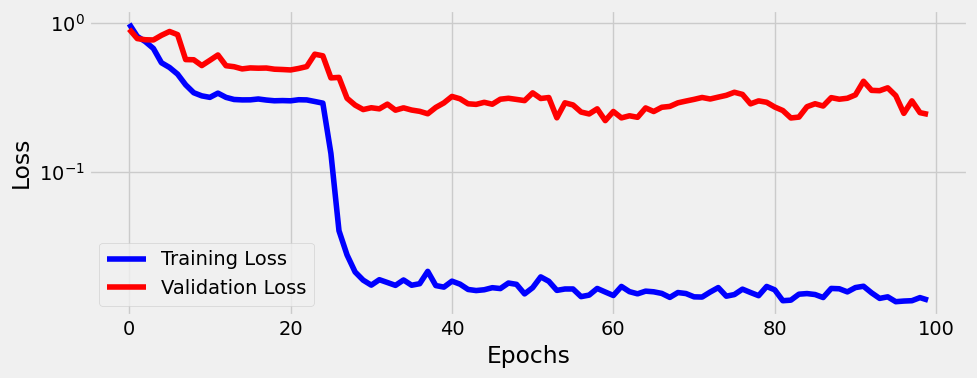

In [29]:
fig = sbs_seq_attention.plot_losses()

###Visualizing Predictions

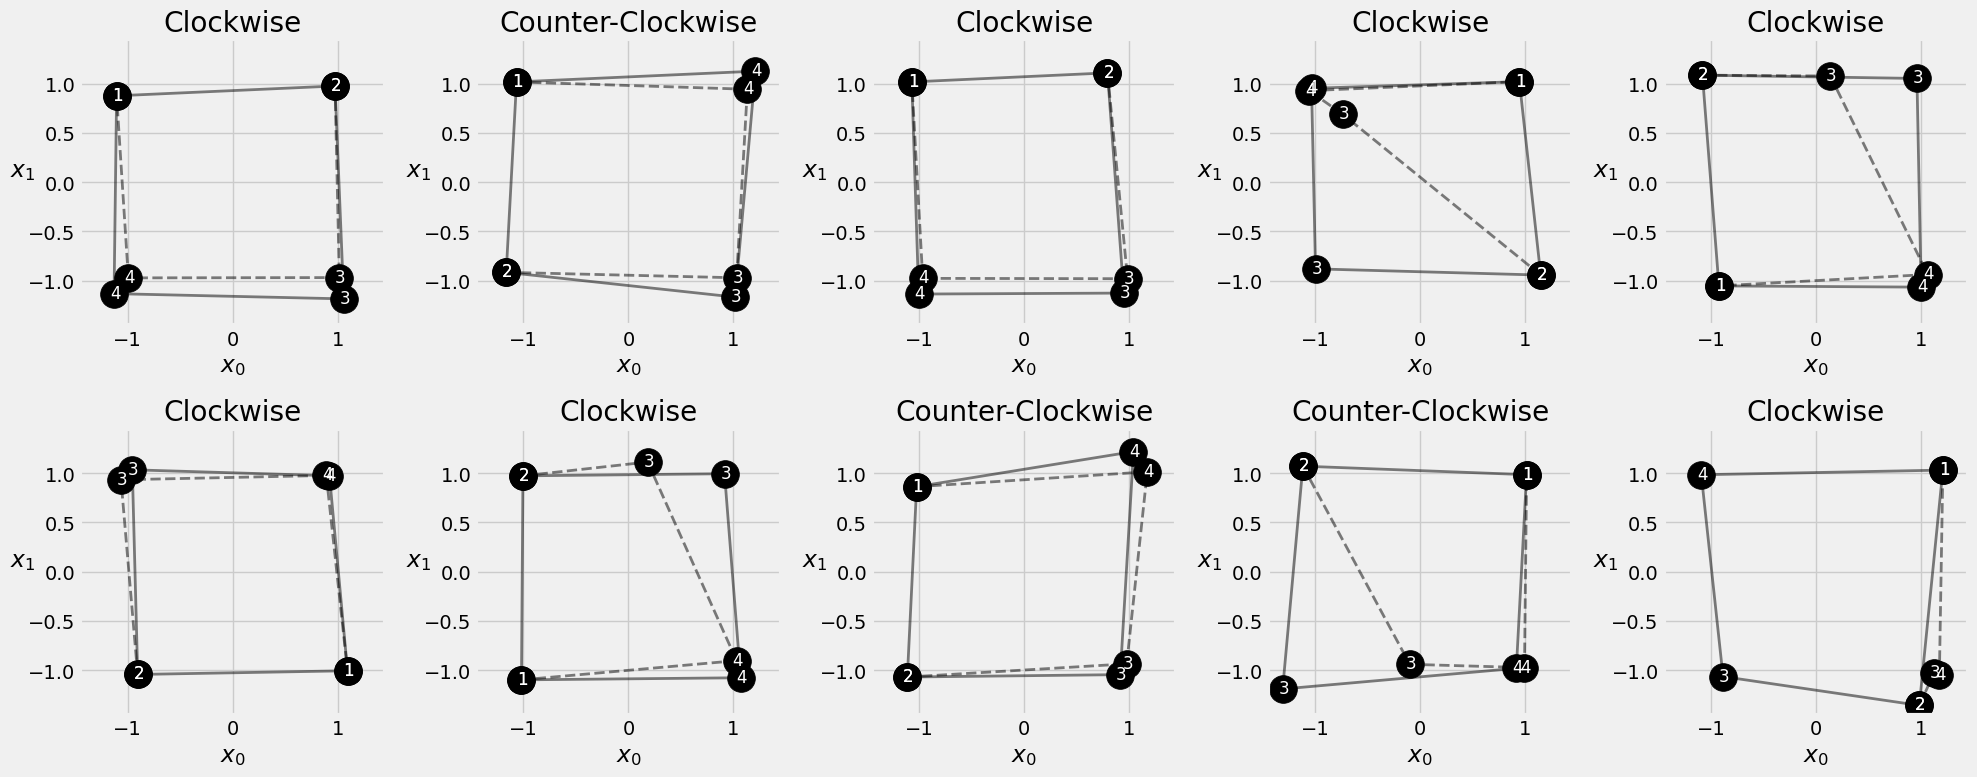

In [30]:
fig = sequence_pred(sbs_seq_attention, full_test, test_directions)

Self-attention is great, indeed, but it is missing one fundamental piece of
information that the recurrent layers had: the order of the data points.

As we know, the order is of utmost importance in sequence problems, but for the selfattention mechanism there is no order to the data points in the source sequence.

###Sequential No More

Let’s compare two encoders, one using recurrent neural networks (left), the other, self-attention (right).

![](https://github.com/rahiakela/deep-learning-research-and-practice/blob/main/deep-learning-with-pytorch-step-by-step/Part-III-NLP/images/encoder_lost_seq.png?raw=1)

The recurrent neural network ensured that the output at each step was fed to the next, depicted by the h0 going from one cell to the next.

Now, compare it to the
encoder using self-attention: Every step is independent of the others. If you flip the
order of the data points in the source sequence, the encoder will output the
"hidden states" in a different order, but it won’t change their values.

That’s exactly what makes it highly parallelizable, and it is both a blessing and a curse. On the one hand, it makes computation very efficient; on the other hand, it is throwing away valuable information.

Can we fix it?

Definitely! Instead of using a model designed to encode the order of the inputs (like the recurrent neural networks), let’s encode the positional information ourselves and add it to the inputs.

##Positional Encoding

We need to find a way to inform the model about the position of every data point
such that it knows the order of the data points. In other words, we need to
generate a unique value for each position in the input.

The first idea that comes to mind is to use the index of the position itself, right?

Let’s just use zero, one, two, and three, done!

What about 'normalizing' the indices?

Sure, we can try that and divide the indices by the length of our sequence (four).

![](https://github.com/rahiakela/deep-learning-research-and-practice/blob/main/deep-learning-with-pytorch-step-by-step/Part-III-NLP/images/posenc_norm4.png?raw=1)

Unfortunately, that didn’t solve the problem—a longer sequence will still generate values larger than one.

![](https://github.com/rahiakela/deep-learning-research-and-practice/blob/main/deep-learning-with-pytorch-step-by-step/Part-III-NLP/images/posenc_norm4_long.png?raw=1)

What about 'normalizing' each sequence by its own length?

It solves that problem, but it raises another one; namely, the same position gets different encoding values depending on the length of the sequence.

![](https://github.com/rahiakela/deep-learning-research-and-practice/blob/main/deep-learning-with-pytorch-step-by-step/Part-III-NLP/images/posenc_mod4mod8.png?raw=1)

Ideally, the positional encoding should remain constant for a given position,
regardless of the length of the sequence.

What if we take the module first, and then 'normalize' it?

![](https://github.com/rahiakela/deep-learning-research-and-practice/blob/main/deep-learning-with-pytorch-step-by-step/Part-III-NLP/images/posenc_modnorm4.png?raw=1)

Well, that indeed solves the two problems above, but the values aren’t unique
anymore.

OK, I give up! How do we handle this?

Let’s think outside the box for a moment; no one said we must use only one vector, right?

Let’s build three vectors instead, using three hypothetical sequence lengths
(four, five, and seven).

![](https://github.com/rahiakela/deep-learning-research-and-practice/blob/main/deep-learning-with-pytorch-step-by-step/Part-III-NLP/images/posenc_modnorm_mult.png?raw=1)

The positional encoding above is unique up to the 140th position and we can easily extend that by adding more vectors.

Our solution still has one problem, and it boils down to
computing distances between two encoded positions.

Let’s take position number
three and its two neighbors, positions number two and four. Obviously, the
distance between position three and each of its closest neighbors is one.

Now, let’s see what happens if we compute distance using the positional encoding.

![](https://github.com/rahiakela/deep-learning-research-and-practice/blob/main/deep-learning-with-pytorch-step-by-step/Part-III-NLP/images/encoded_distances.png?raw=1)

The distance between positions three and two (given by the norm of the difference vector) is not equal to the distance between positions three and four. That may seem a bit too abstract, but using an encoding with inconsistent distances would make it much harder for the model to make sense out of the encoded positions.

This inconsistency arises from the fact that our encoding is resetting to zero every time the module kicks in. The distance between positions three and four got much larger because, at position four, the first vector goes back to zero. We need some other function that has a smoother cycle.

What if we actually use a cycle, I mean, a circle?

Perfect! First, we take our encodings and multiply them by 360.

![](https://github.com/rahiakela/deep-learning-research-and-practice/blob/main/deep-learning-with-pytorch-step-by-step/Part-III-NLP/images/posenc_modnorm_deg.png?raw=1)

Now, each value corresponds to a number of degrees that we can use to move
along a circle.










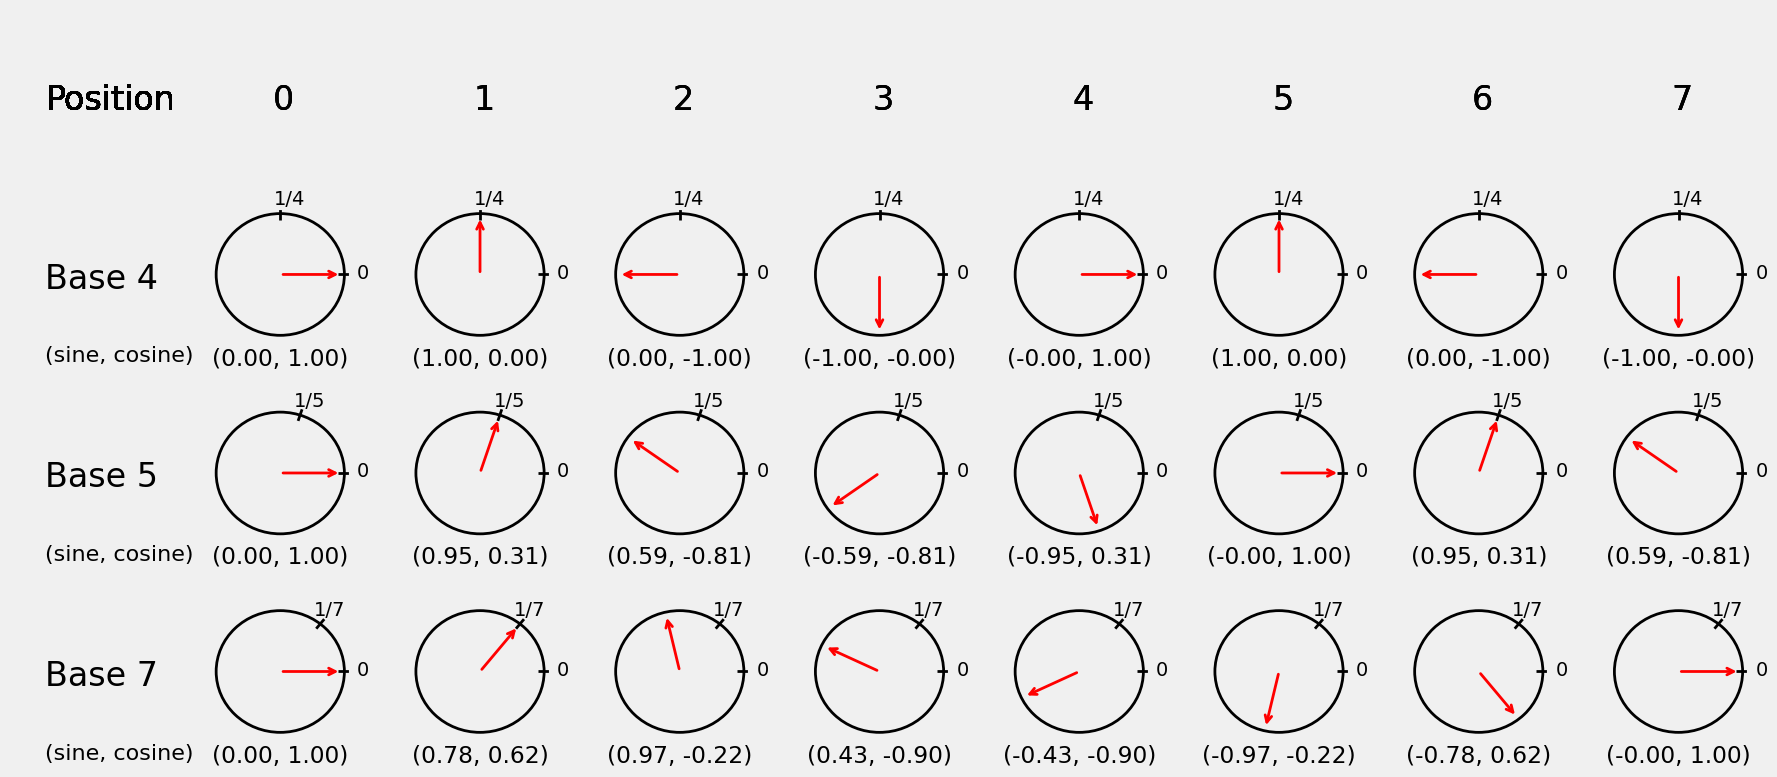

In [31]:
fig = encoding_degrees(dims=3, seqs=(4, 5, 7), tot=8)

Moreover, the circles above show the sine and cosine values corresponding to the coordinates of the tip of each red arrow (assuming a circle with a radius of one).

We can simply read the sine and cosine values, from top to bottom, to build the encodings for each position.

![](https://github.com/rahiakela/deep-learning-research-and-practice/blob/main/deep-learning-with-pytorch-step-by-step/Part-III-NLP/images/posenc_modnorm_sincos.png?raw=1)

There were three vectors, thus generating six coordinates or dimensions (three
sines and three cosines).

Next, let’s use these encodings to calculate the distances, which should be
consistent now!

![](https://github.com/rahiakela/deep-learning-research-and-practice/blob/main/deep-learning-with-pytorch-step-by-step/Part-III-NLP/images/sincos_distance.png?raw=1)

Awesome, isn’t it? The encoded distance between any two positions $T$ steps apart is constant now. In our encoding, the distance between any two positions one step apart will always be 2.03.

Great! But how do I choose the 'bases' for the encoding?






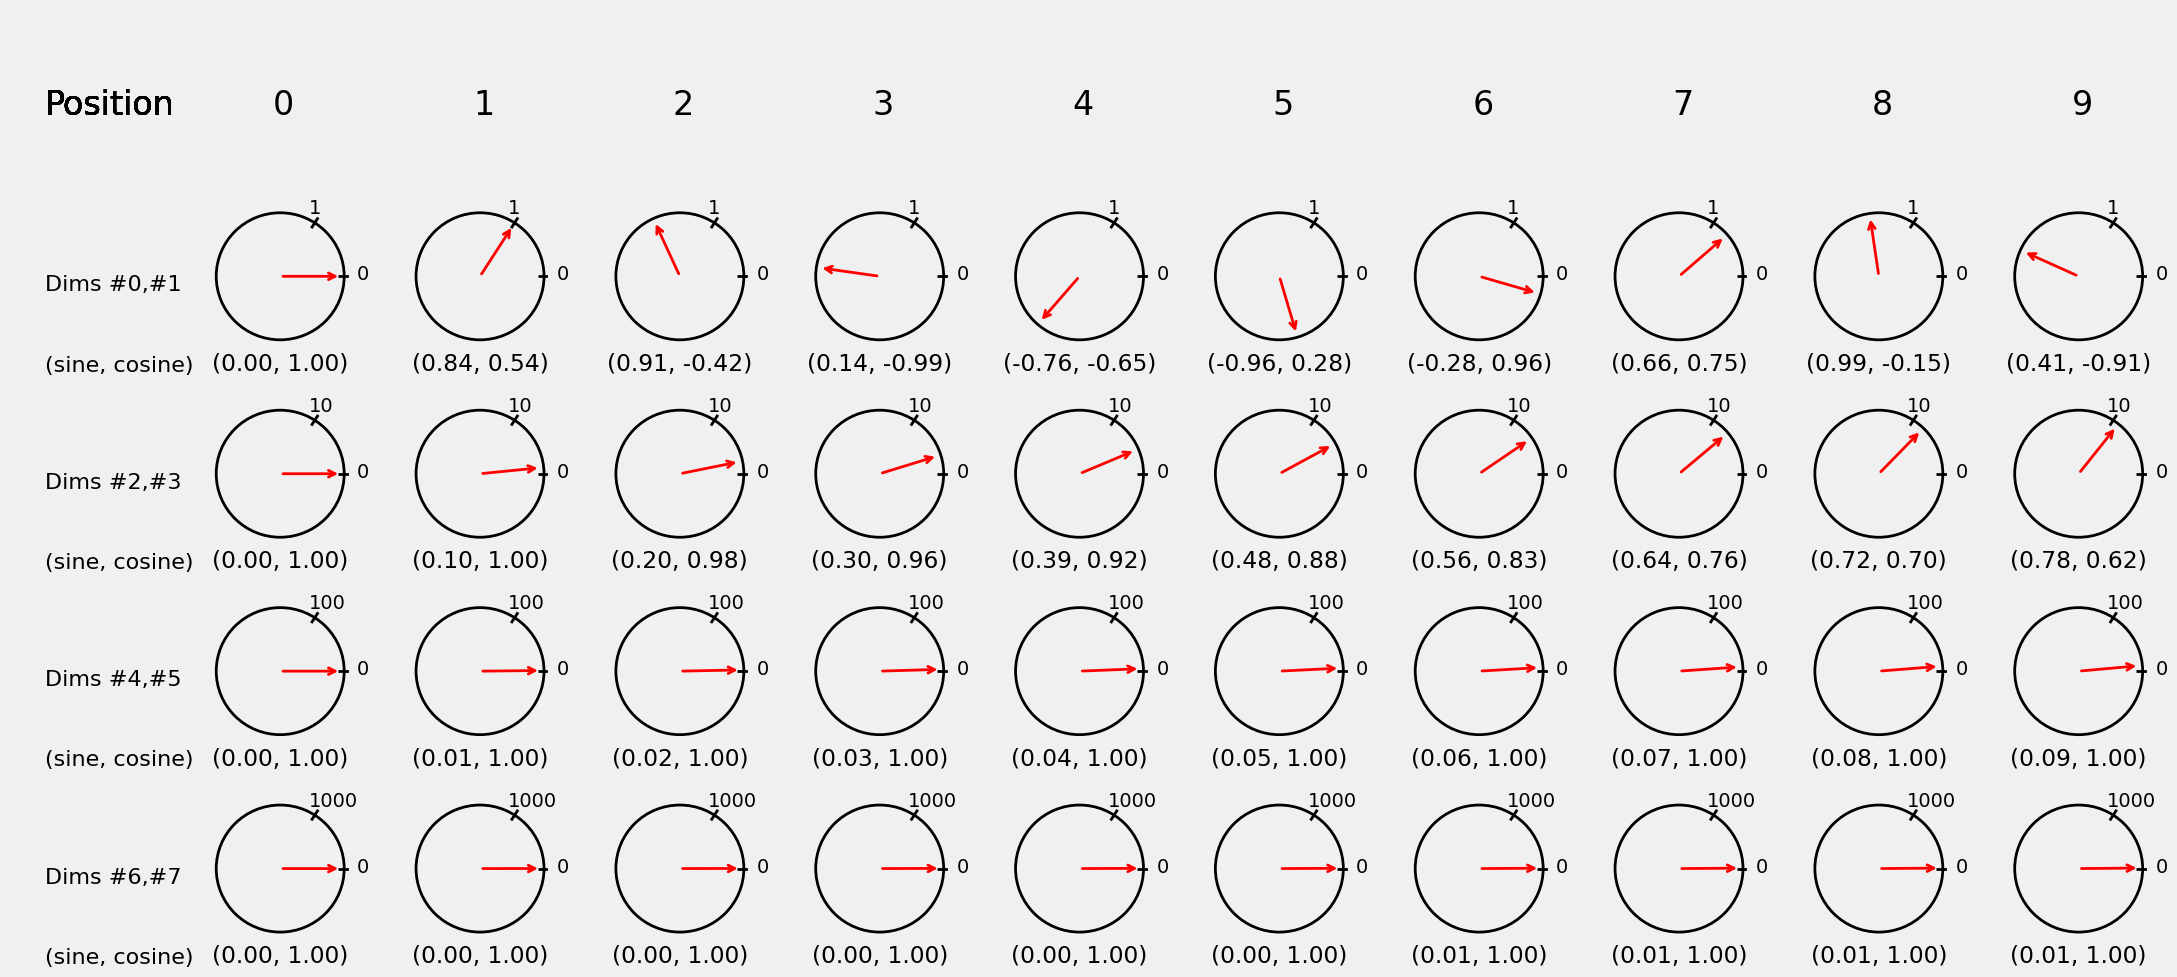

In [32]:
fig = exponential_dials(d_model=8, max_len=10)

Since we’re using four different angular speeds, the positional encoding  has eight dimensions. Notice that the red arrow barely moves in the last two rows.

In practice, we’ll choose the number of dimensions first, and then compute the
corresponding speeds. For example, for encoding with eight dimensions, there are four angular speeds:

$$
\Large
\left(\frac{1}{10000^{\frac{0}{8}}}, \frac{1}{10000^{\frac{2}{8}}}, \frac{1}{10000^{\frac{4}{8}}}, \frac{1}{10000^{\frac{6}{8}}}\right)=(1, 0.1, 0.01, 0.001)
$$

The positional encoding is given by the two formulas below:

$$
\Large
\text{PE}_{\text{pos},\ 2d} = \text{sin} \left(\frac{1}{10000^{\frac{2d}{d_{\text{model}}}}}\text{pos}\right); \text{PE}_{\text{pos},\ 2d+1} = \text{cos} \left(\frac{1}{10000^{\frac{2d}{d_{\text{model}}}}}\text{pos}\right)
$$

Let’s see it in code.

In [33]:
max_len = 10
d_model = 8

position = torch.arange(0, max_len).float().unsqueeze(1)
angular_speed = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))

encoding = torch.zeros(max_len, d_model)
encoding[:, 0::2] = torch.sin(angular_speed * position)
encoding[:, 1::2] = torch.cos(angular_speed * position)

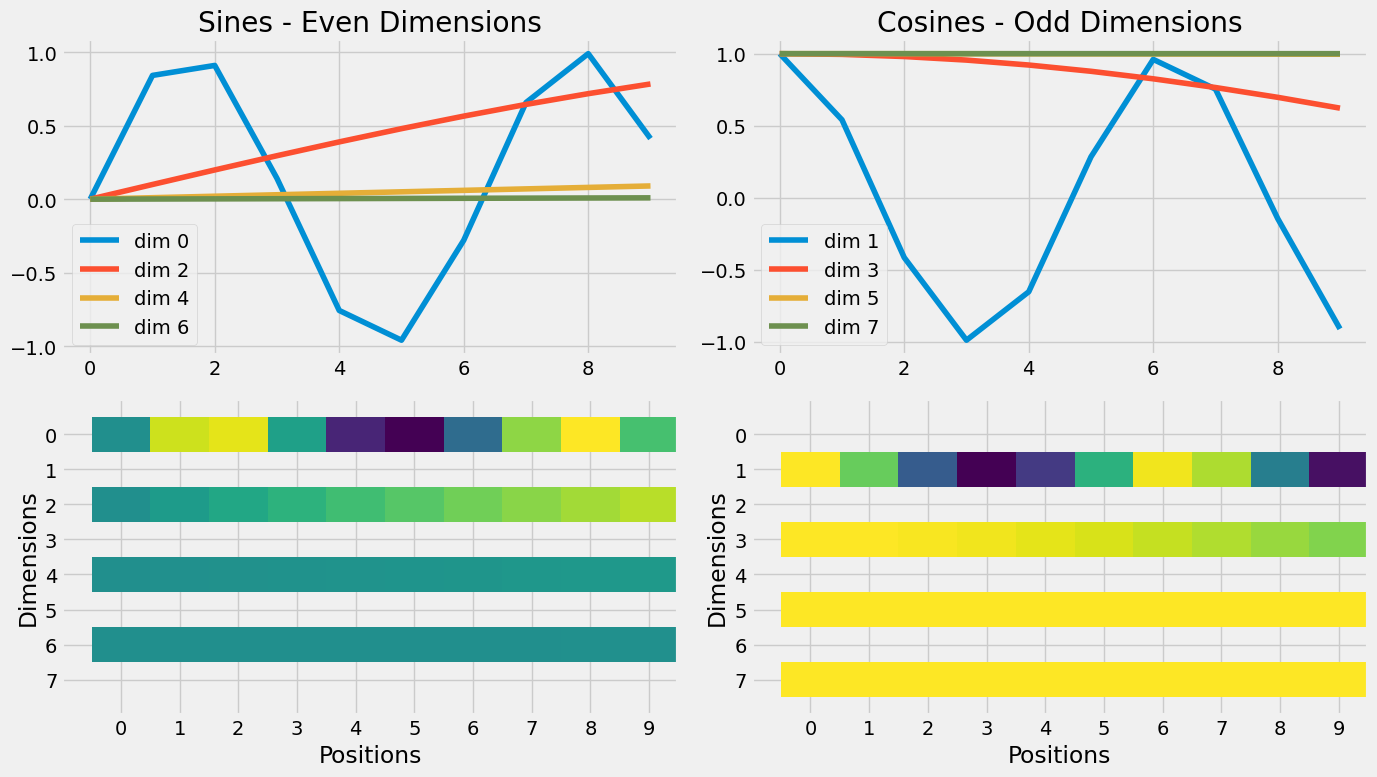

In [34]:
fig = encoding_heatmap(d_model=8, max_len=10)

As you can see, each position is multiplied by several different angular speeds, and
the resulting coordinates (given by the sine and cosine) compose the actual
encoding.

The plots on the bottom show the color-coded encoding, ranging from minus one
(dark blue) to zero (green), all the way to one (yellow).

Let’s put both sine and cosine values together and look at the first four positions:

In [35]:
np.round(encoding[0:4], 4) # first four positions

tensor([[ 0.0000,  1.0000,  0.0000,  1.0000,  0.0000,  1.0000,  0.0000,  1.0000],
        [ 0.8415,  0.5403,  0.0998,  0.9950,  0.0100,  1.0000,  0.0010,  1.0000],
        [ 0.9093, -0.4161,  0.1987,  0.9801,  0.0200,  0.9998,  0.0020,  1.0000],
        [ 0.1411, -0.9900,  0.2955,  0.9553,  0.0300,  0.9996,  0.0030,  1.0000]])

Each line above represents the encoding values for each of its eight dimensions. The first position will always have alternated zeros and ones (the sine and cosine of zero, respectively).

**A Note on Encoded Distances**

The encoded distance between any two positions $T$ steps
apart remains constant.

Let’s illustrate this by computing the encoded
distances among the first five positions (by the way, we’re using the
encoding with eight dimensions now):

In [36]:
distances = np.zeros((5, 5))

for i, v1 in enumerate(encoding[:5]):
  for j, v2 in enumerate(encoding[:5]):
    distances[i, j] = np.linalg.norm(v1 - v2)

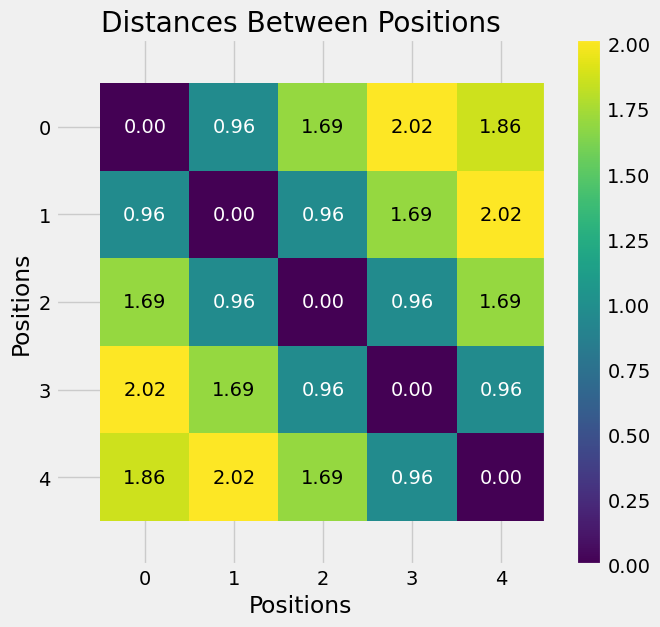

In [37]:
fig, ax = plt.subplots(1, 1, figsize=(7, 6.5))
ax.set_title('Distances Between Positions')
fig = plot_mesh(distances, ax, showvals=True, colorbar=True, ylabel='Positions')

The resulting matrix is full of pretty diagonals, each diagonal containing a
constant value for the encoded distance corresponding to positions $T$ steps
apart.

For example, for positions next to each other $(T=1)$, our encoded distance is
always 0.96. That’s an amazing property of this encoding scheme.


Let’s put it all together into a class:

In [38]:
class PositionalEncoding(nn.Module):
  def __init__(self, max_len, d_model):
    super().__init__()

    self.d_model = d_model
    position_encoding = torch.zeros(max_len, d_model)
    position = torch.arange(0, max_len).float().unsqueeze(1)
    angular_speed = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))

    # even dimensions
    position_encoding[:, 0::2] = torch.sin(angular_speed * position)
    # odd dimensions
    position_encoding[:, 1::2] = torch.cos(angular_speed * position)
    # define an attribute of the module
    self.register_buffer("position_encoding", position_encoding.unsqueeze(0))

  def forward(self, X):
    # x is N, L, D
    # pe is 1, maxlen, D
    # scaling the input before adding the positional encoding
    scaled_x = X * np.sqrt(self.d_model)
    encoded = scaled_x + self.position_encoding[:, :X.size(1), :]
    return encoded

Let’s create an instance of the positional encoding class.

In [39]:
position_encoding = PositionalEncoding(2, 2)
list(position_encoding.parameters()), position_encoding.state_dict()

([],
 OrderedDict([('position_encoding', tensor([[[0.0000, 1.0000],
                        [0.8415, 0.5403]]]))]))

The registered buffer can be accessed just like any other attribute:

In [40]:
position_encoding.position_encoding

tensor([[[0.0000, 1.0000],
         [0.8415, 0.5403]]])

Now, let’s see what happens if we add the positional encoding to a source
sequence:

In [41]:
source_seq # 1, L, D

tensor([[[-1., -1.],
         [-1.,  1.]]])

In [42]:
source_seq + position_encoding.position_encoding

tensor([[[-1.0000,  0.0000],
         [-0.1585,  1.5403]]])

It turns out, the original coordinates were somewhat crowded-out by the addition of the positional encoding (especially the first row). This may happen if the data points have values roughly in the same range as the positional encoding.

Unfortunately, this is fairly common: Both standardized inputs and word
embeddings are likely to have most of their
values inside the `[-1, 1]` range of the positional encoding.

How can we handle it then?

That’s what the scaling in the `forward()` method is for: It’s as if we were "reversing the standardization" of the inputs (using a standard deviation equal to the square root of their dimensionality) to retrieve the hypothetical "raw" inputs.

$$
\Large
\text{standardized}\ x = \frac{\text{"raw"}\ x}{\sqrt{d_x}} \implies \text{"raw"} x = \sqrt{d_x}\ \text{standardized}\ x
$$

In our example, the dimensionality is two (coordinates), so the inputs are going to
be scaled by the square root of two:

In [43]:
position_encoding(source_seq)

tensor([[[-1.4142, -0.4142],
         [-0.5727,  1.9545]]])

For
inputs with many dimensions, the effect will be much more pronounced: A 300-
dimension embedding will have a scaling factor around 17, for example.

Left unchecked, yes, it could be bad for the model. That’s why we’ll pull off yet another normalization trick: layer normalization.

For now, scaling the coordinates by the square root of two isn’t going to be an issue, so we can move on and integrate positional encoding into our model.

###Encoder + Decoder + PE

The new encoder and decoder classes are just wrapping their self-attention
counterparts by assigning the latter to be the layer attribute of the former, and
encoding the inputs prior to calling the corresponding layer:

In [46]:
class EncoderPositionalEncoding(nn.Module):
  def __init__(self, n_heads, d_model, ff_units, n_features=None, max_len=100):
    super().__init__()

    pe_dim = d_model if n_features is None else n_features

    self.position_encoding = PositionalEncoding(max_len, pe_dim)
    self.layer = Encoder(n_heads, d_model, ff_units, n_features)

  def forward(self, query, mask=None):
    pe_query = self.position_encoding(query)
    output = self.layer(pe_query, mask)
    return output

In [50]:
class DecoderPositionalEncoding(nn.Module):
  def __init__(self, n_heads, d_model, ff_units, n_features=None, max_len=100):
    super().__init__()

    pe_dim = d_model if n_features is None else n_features

    self.position_encoding = PositionalEncoding(max_len, pe_dim)
    self.layer = Decoder(n_heads, d_model, ff_units, n_features)

  def init_keys(self, states):
    self.layer.init_keys(states)

  def forward(self, query, source_mask=None, target_mask=None):
    pe_query = self.position_encoding(query)
    output = self.layer(pe_query, source_mask, target_mask)
    return output

###Model Training

Since we haven’t changed the large encoder-decoder model, we only need to
update its arguments (encoder and decoder) to use the new positional encodingpowered
classes:

In [51]:
torch.manual_seed(43)

pe_encoder = EncoderPositionalEncoding(n_heads=3, d_model=2, ff_units=10, n_features=2)
pe_decoder = DecoderPositionalEncoding(n_heads=3, d_model=2, ff_units=10, n_features=2)

model = EncoderDecoder(pe_encoder, pe_decoder, input_len=2, target_len=2)
loss = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [52]:
sbs_seq_attn_pe = StepByStep(model, loss, optimizer)
sbs_seq_attn_pe.set_loaders(train_loader, test_loader)
sbs_seq_attn_pe.train(100)

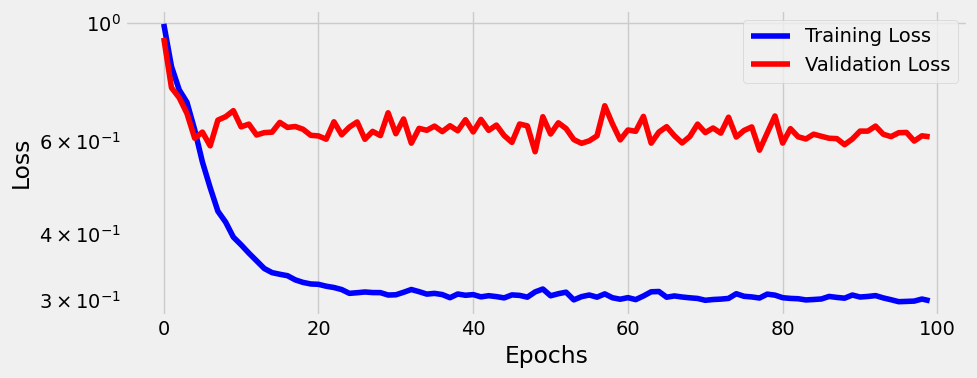

In [53]:
fig = sbs_seq_attn_pe.plot_losses()

###Visualizing Predictions

Let’s plot the predicted coordinates and connect them using dashed lines, while
using solid lines to connect the actual coordinates, just like before:

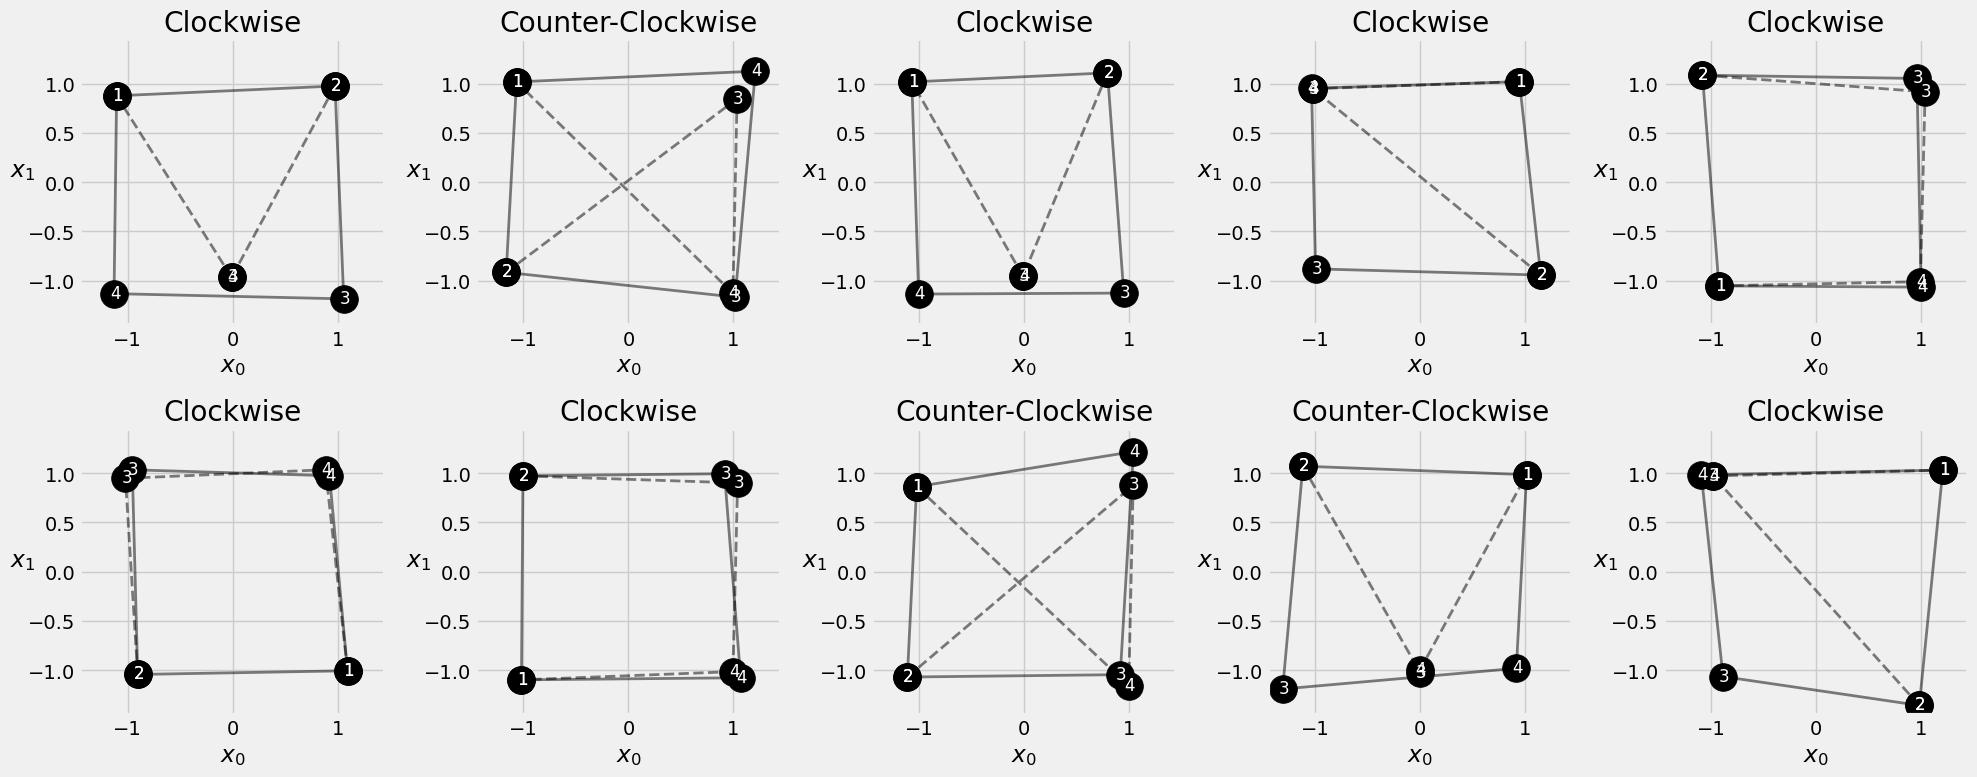

In [54]:
fig = sequence_pred(sbs_seq_attn_pe, full_test, test_directions)

Awesome, it looks like positional encoding is working well indeed—the predicted coordinates are quite close to the actual ones for the most part.

###Visualizing Attention